In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import levene

In [2]:
# Some conventions used for naming result files
envs = ['grid_world', 'cart_pole']
methods = ['no_baseline_', 'learned_baseline', 'SC_baseline']
stochasticity = ['0.0', '0.15', '0.3']

In [4]:
# Load results for Method-1
method_1_file_name = './'+ envs[1] + '_evaluations/s' + stochasticity[0] + '_' + methods[0] + '.pkl'
with open(method_1_file_name, 'rb') as handle:
    method_1 = pickle.load(handle)
    
# Load results for Method-2
method_2_file_name = './'+ envs[1] + '_evaluations/s' + stochasticity[0] + '_' + methods[1] + '.pkl'
with open(method_2_file_name, 'rb') as handle:
    method_2 = pickle.load(handle)
print('Method-1 File name: ', method_1_file_name)
print('Method-2 File name: ', method_2_file_name)

Method-1 File name:  ./cart_pole_evaluations/s0.0_no_baseline_.pkl
Method-2 File name:  ./cart_pole_evaluations/s0.0_learned_baseline.pkl


In [5]:
# Pre-processing of results
method_1_results = method_1['episode_durations']
method_1_results = np.asarray(method_1_results)
method_2_results = method_2['episode_durations']
method_2_results = np.asarray(method_2_results)
# We need to compare both mean and variance of two methods
# For mean we will take mean of last N steps for each run as to get metric of performance in that run
N = 50
# Sufficient statistic from method-1 results
suff_statistic_method_1 = method_1_results[:,-1*N:].mean(axis=1)
suff_statistic_method_2 = method_2_results[:,-1*N:].mean(axis=1)

In [6]:
# Significance testing between mean performance of method-1 and method-2
ttest_pvalue = ttest_ind(suff_statistic_method_1, suff_statistic_method_2)[1]
print(ttest_pvalue)

0.03252681829397809


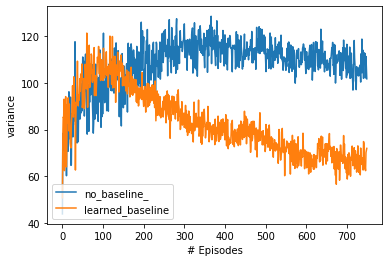

In [46]:
# plot of variance of method-1 and method-2 as a function of epochs
method_1_var = method_1_results.var(axis=0)
method_2_var = method_2_results.var(axis=0)
plt.plot(method_1_var, label=methods[0])
plt.plot(method_2_var, label=methods[1])
plt.legend(loc='lower left')
plt.xlabel('# Episodes')
plt.ylabel('variance')
plt.savefig("plots/" + envs[0]+'_s_' + stochasticity[0]+ '_'+methods[0]+'_vs_'+methods[1]+'.jpeg')
plt.show()

In [7]:
# Significance testing between variance of method-1 and method-2
levenes_test_pvalue = levene(suff_statistic_method_1, suff_statistic_method_2)[1]
print(levenes_test_pvalue)

0.0010081170795343368


In [12]:
def run_significance_testing(env, methods, stoch):
    # Load results for Method-1
    method_1_file_name = './'+ env + '_evaluations/s' + stoch + '_' + methods[0] + '.pkl'
    with open(method_1_file_name, 'rb') as handle:
        method_1 = pickle.load(handle)

    # Load results for Method-2
    method_2_file_name = './'+ env + '_evaluations/s' + stoch + '_' + methods[1] + '.pkl'
    with open(method_2_file_name, 'rb') as handle:
        method_2 = pickle.load(handle)
        
    # Load results for Method-3
    method_3_file_name = './'+ env + '_evaluations/s' + stoch + '_' + methods[2] + '.pkl'
    with open(method_3_file_name, 'rb') as handle:
        method_3 = pickle.load(handle)
    print('Method-1 File name: ', method_1_file_name)
    print('Method-2 File name: ', method_2_file_name)
    print('Method-3 File name: ', method_3_file_name)
    
    # Pre-processing of results
    method_1_results = method_1['episode_durations']
    method_1_results = np.asarray(method_1_results)
    method_2_results = method_2['episode_durations']
    method_2_results = np.asarray(method_2_results)
    method_3_results = method_3['episode_durations']
    method_3_results = np.asarray(method_3_results)
    # We need to compare both mean and variance of two methods
    # For mean we will take mean of last N steps for each run as to get metric of performance in that run
    N = 50
    # Sufficient statistic from method-1 results
    suff_statistic = {}
    suff_statistic[methods[0]] = method_1_results[:,-1*N:].mean(axis=1)
    suff_statistic[methods[1]] = method_2_results[:,-1*N:].mean(axis=1)
    suff_statistic[methods[2]] = method_3_results[:,-1*N:].mean(axis=1)
    
    names = {}
    names[methods[0]] = "No Baseline"
    names[methods[1]] = "Learned Baseline"
    names[methods[2]] = "Self Critic Baseline"
    
    # plot of std deviations of methods as a function of epochs
    method_1_var = method_1_results.var(axis=0)
    method_2_var = method_2_results.var(axis=0)
    method_3_var = method_3_results.var(axis=0)
    plt.plot(np.sqrt(method_1_var), label=names[methods[0]])
    plt.plot(np.sqrt(method_2_var), label=names[methods[1]])
    plt.plot(np.sqrt(method_3_var), label=names[methods[2]])
    plt.legend(loc='lower right')
    plt.xlabel('# Episodes')
    plt.ylabel('std. deviation')
    plt.ylim(top=80)
    plt.savefig("plots/std_" + env +'_s_' + stoch + '.png')
    plt.show()
    
    # plot of mean of runs of methods as a function of epochs
    method_1_mean = method_1_results.mean(axis=0)
    method_2_mean = method_2_results.mean(axis=0)
    method_3_mean = method_3_results.mean(axis=0)
    plt.plot(method_1_mean, label=names[methods[0]])
    plt.plot(method_2_mean, label=names[methods[1]])
    plt.plot(method_3_mean, label=names[methods[2]])
    plt.legend(loc='lower right')
    plt.xlabel('# Episodes')
    plt.ylabel('average duration')
    plt.ylim(top=200)
    plt.savefig("plots/average_duration_" + env +'_s_' + stoch + '.png')
    plt.show()
    
    significance_var = np.ndarray(shape=(3,3))
    significance_mean = np.ndarray(shape=(3,3))
    for i,meth_1 in enumerate(methods):
        for j,meth_2 in enumerate(methods):
            # Significance testing between mean performance of method-1 and method-2
            ttest_pvalue = ttest_ind(suff_statistic[meth_1], suff_statistic[meth_2])[1]
            significance_var[i][j] = ttest_pvalue
    
            # Significance testing between variance of method-1 and method-2
            levenes_test_pvalue = levene(suff_statistic[meth_1], suff_statistic[meth_2])[1]
            significance_mean[i][j] = ttest_pvalue
    print("variance significance table:\n", significance_var)
    print("mean significance table:\n", significance_mean)
    f = open("results/" + env + "_" + stoch + ".txt","w+")
    f.write("variance significance table:\n")
    np.savetxt(f, significance_var)
    f.write("mean significance table:\n")
    np.savetxt(f, significance_mean)
    f.close()

Method-1 File name:  ./cart_pole_evaluations/s0.0_no_baseline_.pkl
Method-2 File name:  ./cart_pole_evaluations/s0.0_learned_baseline.pkl
Method-3 File name:  ./cart_pole_evaluations/s0.0_SC_baseline.pkl


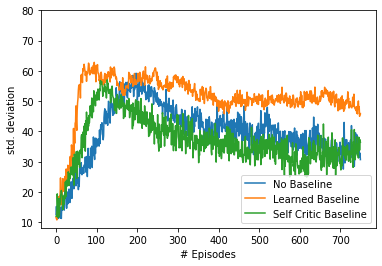

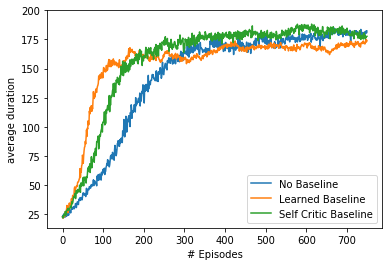

variance significance table:
 [[1.         0.03252682 0.63149466]
 [0.03252682 1.         0.06683623]
 [0.63149466 0.06683623 1.        ]]
mean significance table:
 [[1.         0.03252682 0.63149466]
 [0.03252682 1.         0.06683623]
 [0.63149466 0.06683623 1.        ]]
Method-1 File name:  ./cart_pole_evaluations/s0.15_no_baseline_.pkl
Method-2 File name:  ./cart_pole_evaluations/s0.15_learned_baseline.pkl
Method-3 File name:  ./cart_pole_evaluations/s0.15_SC_baseline.pkl


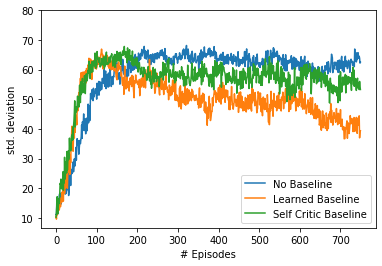

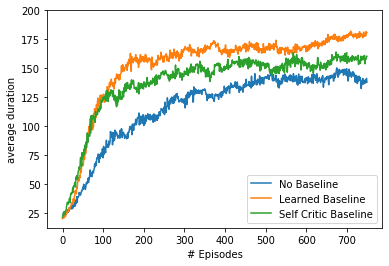

variance significance table:
 [[1.00000000e+00 1.15814460e-12 4.24789056e-03]
 [1.15814460e-12 1.00000000e+00 1.15982395e-05]
 [4.24789056e-03 1.15982395e-05 1.00000000e+00]]
mean significance table:
 [[1.00000000e+00 1.15814460e-12 4.24789056e-03]
 [1.15814460e-12 1.00000000e+00 1.15982395e-05]
 [4.24789056e-03 1.15982395e-05 1.00000000e+00]]
Method-1 File name:  ./cart_pole_evaluations/s0.3_no_baseline_.pkl
Method-2 File name:  ./cart_pole_evaluations/s0.3_learned_baseline.pkl
Method-3 File name:  ./cart_pole_evaluations/s0.3_SC_baseline.pkl


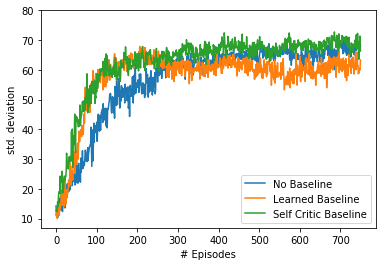

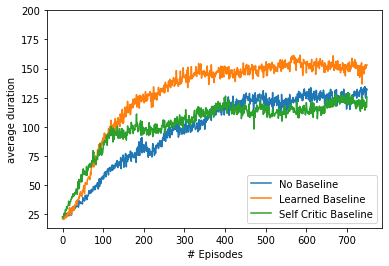

variance significance table:
 [[1.00000000e+00 3.07413785e-05 2.81626139e-01]
 [3.07413785e-05 1.00000000e+00 1.56922264e-07]
 [2.81626139e-01 1.56922264e-07 1.00000000e+00]]
mean significance table:
 [[1.00000000e+00 3.07413785e-05 2.81626139e-01]
 [3.07413785e-05 1.00000000e+00 1.56922264e-07]
 [2.81626139e-01 1.56922264e-07 1.00000000e+00]]


In [13]:
for env in [envs[1]]:
    for stoch in stochasticity:
        run_significance_testing(env, methods, stoch)

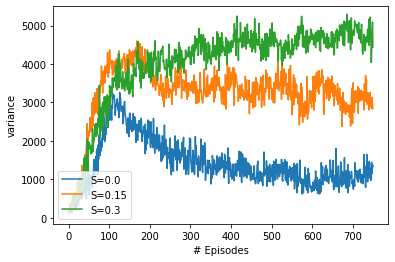

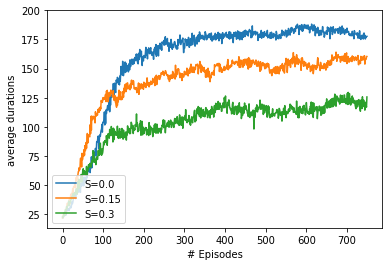

In [7]:
durations = {}
var = {}
for stoch in stochasticity:
    method_1_file_name = './'+ env + '_evaluations/s' + stoch + '_' + methods[2] + '.pkl'
    with open(method_1_file_name, 'rb') as handle:
        method_1 = pickle.load(handle)
    method_1_results = method_1['episode_durations']
    method_1_results = np.asarray(method_1_results)
    var[stoch] = method_1_results.var(axis=0)
    durations[stoch] = method_1_results.mean(axis=0)
plt.plot(np.sqrt(var[stochasticity[0]]), label="S=" + stochasticity[0])
plt.plot(np.sqrt(var[stochasticity[1]]), label="S=" + stochasticity[1])
plt.plot(np.sqrt(var[stochasticity[2]]), label="S=" + stochasticity[2])
plt.legend(loc='lower left')
plt.xlabel('# Episodes')
plt.ylabel('std. deviation')
plt.ylim(top=80)
plt.savefig("plots/std_" + env + "_SC_baseline" + '.png')
plt.show()

plt.plot(durations[stochasticity[0]], label="S=" + stochasticity[0])
plt.plot(durations[stochasticity[1]], label="S=" + stochasticity[1])
plt.plot(durations[stochasticity[2]], label="S=" + stochasticity[2])
plt.legend(loc='lower left')
plt.xlabel('# Episodes')
plt.ylabel('average durations')
plt.ylim(top=200)
plt.savefig("plots/average_durations_" + env + "_SC_baseline" + '.png')
plt.show()